#### 1223 Турчин
### ДЗ-8. Проверяем работу модели на практике: A/B-тестирование


## Домашнее задание
<font color=blue size=4> 
    <hr>


1. Взять датасет из google диска: https://drive.google.com/file/d/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.<br>
    
<hr>

Постановка задачи:
- Есть отток
- можно бороться с оттоком рассылая предложения по тарифу
- Коммуникации проходят по случайной выборке клиентов (если это отток, то делаем предложение в объеме, которое примет 50% клиентов)

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
df = pd.read_csv('marketing_campaign.csv')
df

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


In [5]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['converted'],axis=1), df['converted'], random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2)

In [6]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns ]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p = 2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key+str(i) for i in range(1,self.p) ]
        self.columns = B+['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index,columns =[self.columns] )
        return B[self.columns]     

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5645 entries, 8202 to 858
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             5645 non-null   object
 1   date_served         5642 non-null   object
 2   marketing_channel   5642 non-null   object
 3   variant             5645 non-null   object
 4   language_displayed  5645 non-null   object
dtypes: object(5)
memory usage: 264.6+ KB


In [8]:
X_train.describe()

,user_id,date_served,marketing_channel,variant,language_displayed
count,5645,5642,5642,5645,5645
unique,5645,31,5,2,4
top,a9202,1/15/18,House Ads,control,English
freq,1,425,2663,2847,5502


In [9]:
X_train.head(3)

,user_id,date_served,marketing_channel,variant,language_displayed
8202,a9202,1/11/18,House Ads,personalization,English
6376,a7376,1/9/18,Facebook,personalization,English
2147,a3147,1/15/18,House Ads,control,English


In [10]:
X_train.columns

Index(['user_id', 'date_served', 'marketing_channel', 'variant',
       'language_displayed'],
      dtype='object')

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:,2:].select_dtypes(include=numerics).columns:
    sns.kdeplot(X_train.loc[y_train == 1,i], label='1 train')
    sns.kdeplot(X_train.loc[y_train == 0,i], ls='--', label='0 train')
    
    sns.kdeplot(X_val.loc[y_val == 1,i], label='1 val')
    sns.kdeplot(X_val.loc[y_val == 0,i], ls='--', label='0 val')
    
    sns.kdeplot(X_test.loc[y_test == 1,i], label='1 test')
    sns.kdeplot(X_test.loc[y_test == 0,i], ls='--', label='0 test')
    plt.title(i)
    plt.legend()
    plt.show()       

In [12]:
categorical_col =  ['marketing_channel', 'variant',  'language_displayed']

for i in categorical_col:
    print(i,' число уникальных значений: ', len(pd.unique(X_train[i])), 'уникальные значения', pd.unique(X_train[i]))

marketing_channel  число уникальных значений:  6 уникальные значения ['House Ads' 'Facebook' 'Instagram' 'Push' 'Email' nan]
variant  число уникальных значений:  2 уникальные значения ['personalization' 'control']
language_displayed  число уникальных значений:  4 уникальные значения ['English' 'German' 'Spanish' 'Arabic']


In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for i in X_train.iloc[:,2:].select_dtypes(include=numerics).columns:
    tr_v_stats = mannwhitneyu(X_train.loc[y_train == 1, i], X_val.loc[y_val == 1, i])
    tr_test_stats = mannwhitneyu(X_train.loc[y_train == 1, i], X_test.loc[y_test == 1, i])
    print(i, ':', tr_v_stats[1], ':', tr_test_stats[1])

In [14]:
categorical_columns = ['Geography']
continuous_columns = ['CreditScore','Tenure', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_bin_columns = ['Gender',  'HasCrCard', 'IsActiveMember']


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoderBin(key='Gender'))
            ])

gender.fit(X_train)
gender.transform(X_test).head(3)

KeyError: 'Gender'

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

geography = Pipeline([
                ('selector', FeatureSelector(column='Geography')),
                ('ohe', OHEEncoder(key='Geography'))
            ])
geography.fit(X_train)
geography.transform(X_test).head(3)

,Geography_France,Geography_Germany,Geography_Spain
7878,1,0,0
3224,0,1,0
1919,1,0,0


In [22]:
Age = Pipeline([
                ('selector', FeatureSelector(column='Age')),
                ('ohe', NumericPower(key='Age', p=3))
            ])

Age.fit(X_train)
print(Age.transform(X_test).head(3))

      Age1    Age2      Age3       log
7878  38.0  1444.0   54872.0  3.663562
3224  41.0  1681.0   68921.0  3.737670
1919  56.0  3136.0  175616.0  4.043051


In [19]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('pow_2', NumericPower(key=cont_col, p=3)),
                ('Scale', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


for bin_col in categorical_bin_columns:
    bin_transformer = Pipeline([
                ('selector', FeatureSelector(column=bin_col)),
                ('ohe', OHEEncoderBin(key=bin_col))
            ])
    final_transformers.append((bin_col, bin_transformer))

In [20]:
final_transformers

[('Geography',
  Pipeline(steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))])),
 ('CreditScore',
  Pipeline(steps=[('selector', NumberSelector(key='CreditScore')),
                  ('pow_2', NumericPower(key='CreditScore', p=4)),
                  ('Scale', StandardScaler())])),
 ('Tenure',
  Pipeline(steps=[('selector', NumberSelector(key='Tenure')),
                  ('pow_2', NumericPower(key='Tenure', p=4)),
                  ('Scale', StandardScaler())])),
 ('Age',
  Pipeline(steps=[('selector', NumberSelector(key='Age')),
                  ('pow_2', NumericPower(key='Age', p=4)),
                  ('Scale', StandardScaler())])),
 ('Balance',
  Pipeline(steps=[('selector', NumberSelector(key='Balance')),
                  ('pow_2', NumericPower(key='Balance', p=4)),
                  ('Scale', StandardScaler())])),
 ('NumOfProducts',
  Pipeline(steps=[('selector', NumberSelector(key='NumOfProducts')),
                

In [21]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [22]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

KeyError: 'Geography'

In [15]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_val)[:, 1]
preds[:10]

NameError: name 'pipeline' is not defined

In [28]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.320000, F-Score=0.599, Precision=0.571, Recall=0.630


Confusion matrix, without normalization
[[1281  191]
 [ 149  254]]


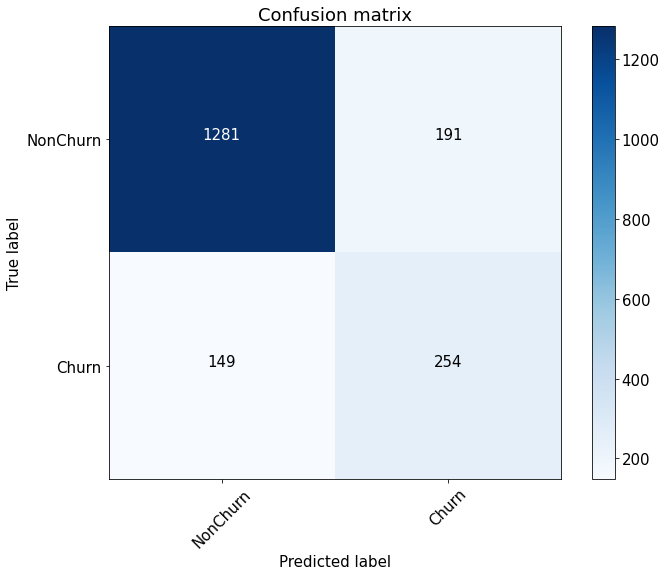

In [29]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
# Конверсия

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

C0 = (TP + FN) / np.sum(cnf_matrix)
C0

0.21493333333333334



Начинаем A/B тест:

базовая конверсия 0.214<br>

In [33]:
X_test.shape

(2500, 13)

In [34]:
X_A, X_B, y_A, y_B = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

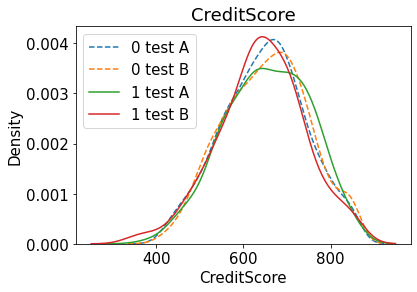

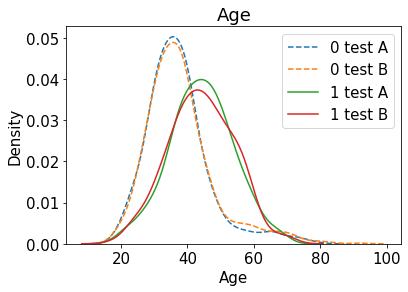

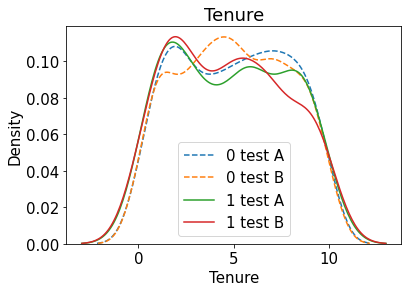

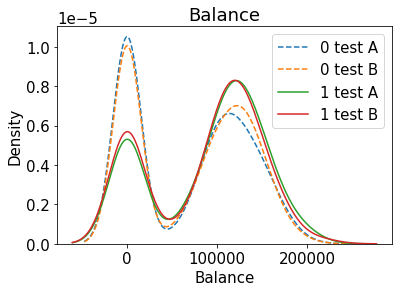

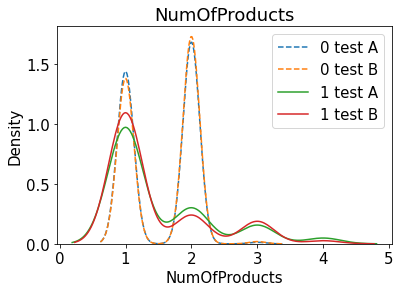

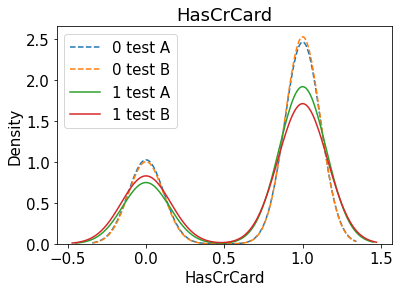

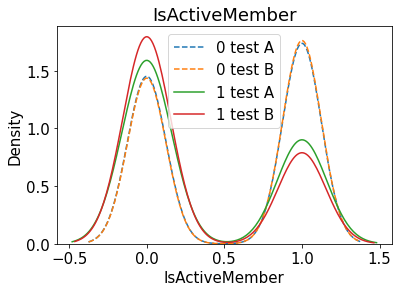

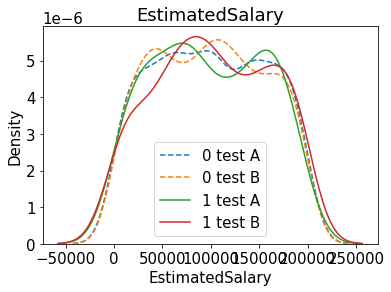

In [35]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:, 2:].select_dtypes(include=numerics).columns:
    sns.kdeplot(X_A.loc[y_A == 0,i], ls='--', label='0 test A')
    sns.kdeplot(X_B.loc[y_B == 0,i], ls='--', label='0 test B')
    
    sns.kdeplot(X_A.loc[y_A == 1,i], label='1 test A')
    sns.kdeplot(X_B.loc[y_B == 1,i], label='1 test B')
    plt.title(i)
    plt.legend()
    plt.show() 

In [36]:
predsB = pipeline.predict_proba(X_B)[:, 1]
cnf_matrix = confusion_matrix(y_B, predsB > thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(cnf_matrix)

[[912  99]
 [ 89 150]]


In [37]:
churn_ef = 0.5  # Снижение эффективности предсказания за счет не полного действия мер по борьбе с оттоком
C0_A = (np.sum(y_A)) / y_A.shape[0] # churn rate (коэффициента оттока клиентов) без ML
print(C0_A)
C1_MLB = (FN + (1-churn_ef) * TP) / np.sum(cnf_matrix) # churn rate (коэффициента оттока клиентов) при ML
print(C1_MLB)

0.1968
0.1312


In [38]:
y_churnA = y_A

y_pred = (predsB > thresholds[ix])
ind_churn = np.where((y_pred != y_B) & (y_B == 1))
y_churnB = np.zeros(y_B.shape)
y_churnB[ind_churn] = 1


k1, n1 = np.sum(y_A), y_A.shape[0]
k2, n2 = np.sum(y_churnB), y_churnB.shape[0]
k1, k2, n1, n2

(246, 89.0, 1250, 1250)

In [39]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=9.218 pvalue=0.000


In [41]:
#---------------------------------------

In [46]:
marketing_campaign = pd.read_csv('marketing_campaign.csv')
marketing_campaign

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


In [47]:
marketing_campaign.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [48]:
marketing_campaign.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64